In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import random
%matplotlib inline

In [42]:
args = {'lr':0.01,
        'train epochs':500,
        'hidden layers':10,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'correlation':0.0,
        'input features': 40,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        }

now = datetime.now()

# Data Prep

In [43]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [44]:
df = pd.read_excel('data_3nm.xlsx')

In [45]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [46]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [47]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [48]:
# add noise
X_noisy = add_noise(X, args['noise'])

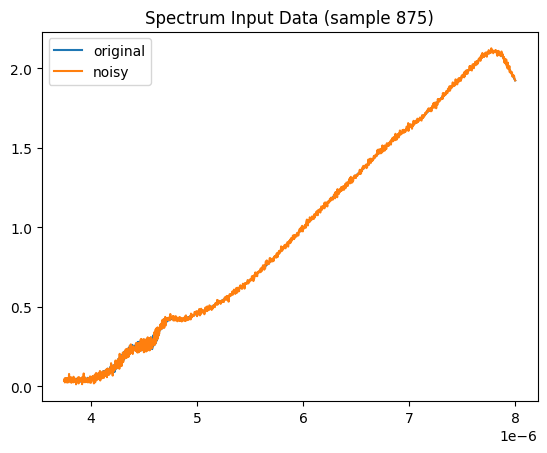

In [49]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [50]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [52]:
for layer in layers:
    inputs = X_train
    targets = y_train[layer['col']]

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['input features'])

    rfe.fit(inputs, targets)

    selected_features = X.columns[rfe.support_]

    layer['features'] = selected_features

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')


'''# select features that correlate more than given amount
for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]
    
    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.abs().iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
    
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')'''


KeyboardInterrupt: 

In [ ]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

    # 

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [ ]:
criterion = args['train criterion']

In [ ]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    # instantiate model
    model = FeedForward(input.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(input)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
hidden layer sizes: [1417, 1328, 1239, 1151, 1062, 974, 885, 797, 708, 619, 531, 442, 354, 265, 177, 88]
epoch: 50, loss = 77.64405059814453
epoch: 100, loss = 7.619572639465332
epoch: 150, loss = 4.609361171722412
epoch: 200, loss = 3.798182487487793
epoch: 250, loss = 3.3727164268493652
epoch: 300, loss = 3.1588757038116455
epoch: 350, loss = 2.969057559967041
epoch: 400, loss = 2.9216504096984863
epoch: 450, loss = 2.740389347076416
epoch: 500, loss = 2.7284839153289795
best loss: 2.6605658531188965 in epoch 499

layer 2
hidden layer sizes: [1417, 1328, 1239, 1151, 1062, 974, 885, 797, 708, 619, 531, 442, 354, 265, 177, 88]
epoch: 50, loss = 77.24011993408203
epoch: 100, loss = 12.456472396850586
epoch: 150, loss = 7.866323947906494
epoch: 200, loss = 6.377163887023926
epoch: 250, loss = 5.65289306640625
epoch: 300, loss = 5.272095203399658
epoch: 350, loss = 4.902379512786865
epoch: 400, loss = 4.848780155181885
epoch: 450, loss = 4.618269443511963
epoch: 500, loss = 4.6132

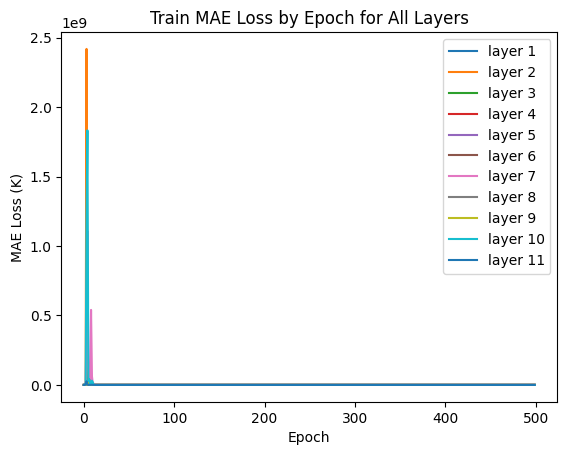

In [ ]:
for layer in layers:
    plt.plot(layer['train losses'], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [ ]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

print(f"Average: {sum(test_losses)/len(test_losses)}")

layer 1 loss: 9.338644027709961
layer 2 loss: 17.0958194732666
layer 3 loss: 6.159597396850586
layer 4 loss: 8.45030689239502
layer 5 loss: 9.405208587646484
layer 6 loss: 9.061884880065918
layer 7 loss: 10.522022247314453
layer 8 loss: 9.877340316772461
layer 9 loss: 13.558124542236328
layer 10 loss: 6.384014129638672
layer 11 loss: 8.967494010925293
Average: 9.892768773165615


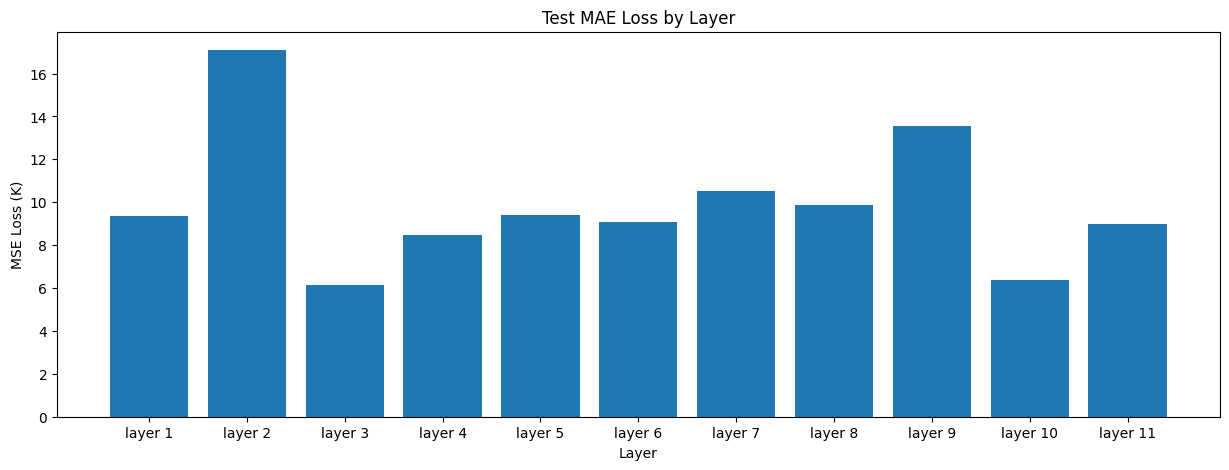

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [ ]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [ ]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

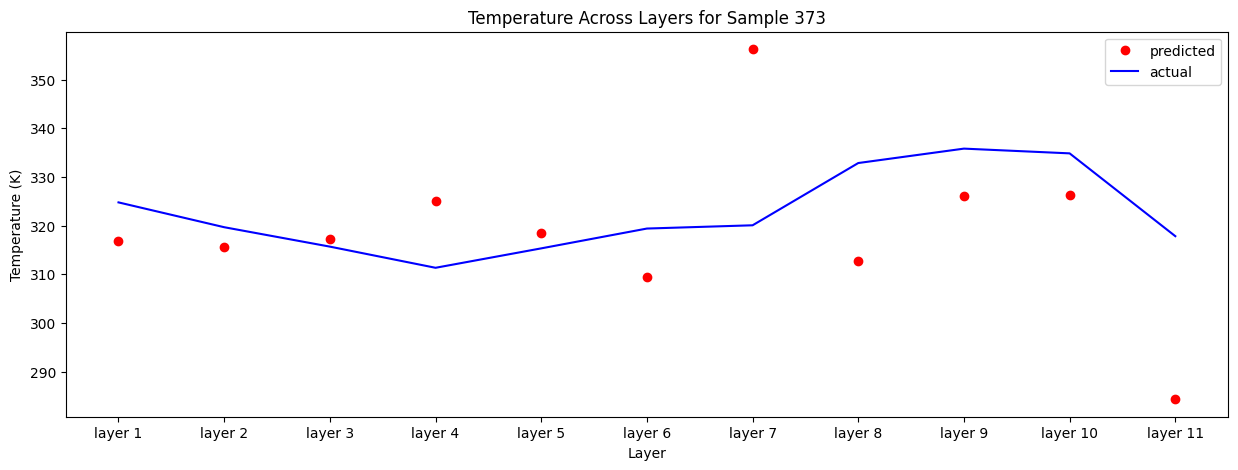

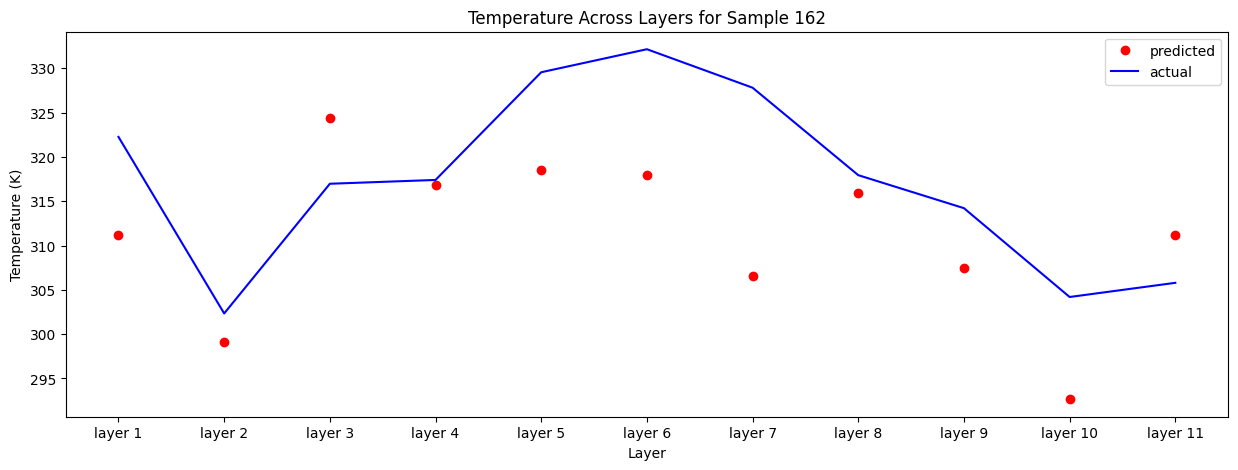

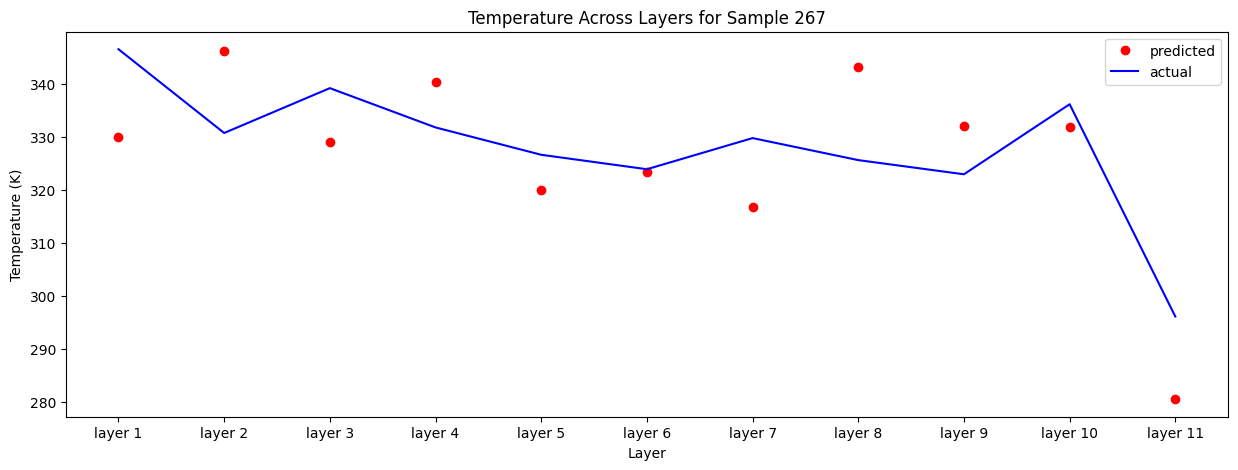

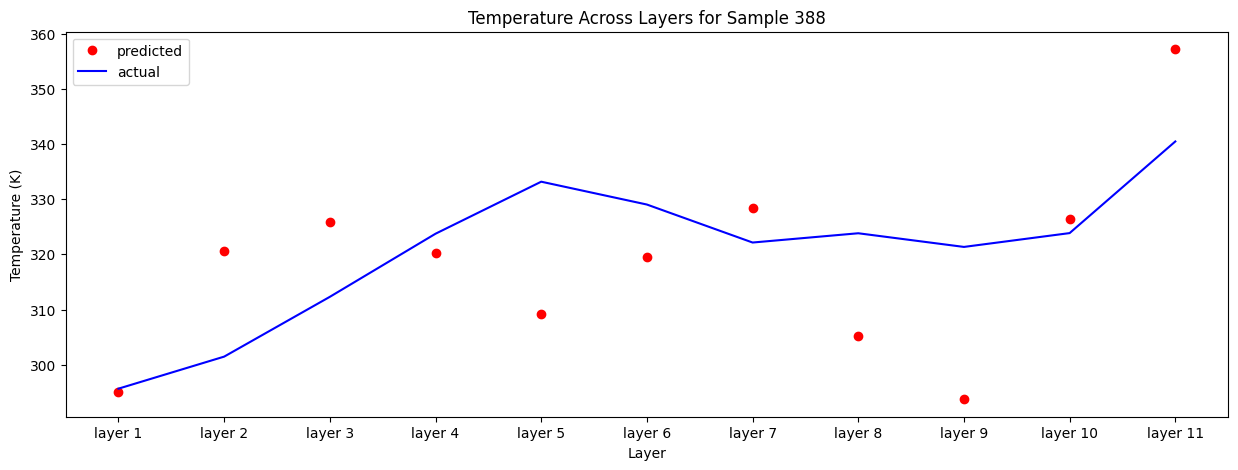

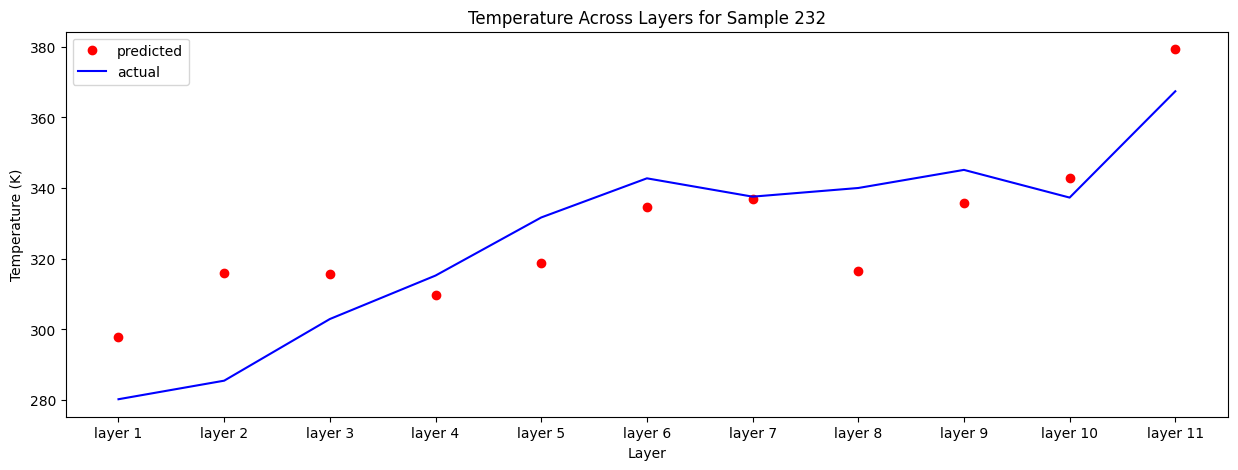

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)

In [ ]:
with open('ff_one_layer_test.txt', "a") as f:
    f.write('===================================\n' +'|'.ljust(5) + f'{now.strftime("%m/%d/%Y, %H:%M:%S")}\n|\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'| layer {i} loss: '.ljust(20) + f'{test_losses[i-1]:.3f}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'| {key}:'.ljust(20) + f'{args[key]}\n'

    f.write('|'.ljust(10) + 'Losses\n' + f'|----------------------------------\n{loss_str}|\n'+ '|'.ljust(10) + 'Args' 
            + f'\n|----------------------------------\n{arg_str}====================================\n\n')